In [1]:
import sys 
sys.path.append('../src/')

In [168]:
import numpy as np
import pennylane as qml
from jax import jit
from opt_einsum import contract
import ANNNIgen
import mpsgen
import os
from typing import Tuple, List, Callable

import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

class state:
    def __init__(self, L : int, h : float, k : float, shapes : np.ndarray, tensors : np.ndarray, towave_func : Callable):
        self.L, self.h, self.k = L, h, k
        self.shapes = shapes.astype(int)
        # This needs some explanation:
        # 1. Start from `tensors`, it is just a list of value that have to be grouped in smaller
        #    tensors according to the shapes list, that defines the list of the smaller tensors
        # 2. Compute self.splits, it tells the indexes for splitting the full vector into
        #    the smaller tensors
        #    EX:
        #        [a,b,c,d,e,f,g,h] : full vector
        #         0 1 2 3 4 5 6 7    index
        #        [2,6]             : self.splits
        #        self.splits tells you how to break the full vector
        #        [a,b] [c,d,e,f] [g,h] : split vectors
        self.splits = np.cumsum(np.prod(shapes, axis=1)).astype(int)
        # 3. Compute the MPS:
        #     3.1: Group the elements in split vectors (not split tensors yet)
        #          np.array_split(tensors, self.splits)[:-1] 
        #          flat_tn = np.array_split(tensors, self.splits)[:-1] split vectors, List of L vectors
        #                    NOTE: np.array_split(tensors, self.splits)[-1] is empty
        #     3.2: Reshape each of the L vector into tensor with the shape declared in self.shape
        # 3.1 and 3.2 done together to avoid garbage collector shenanigans
        self.MPS = [site.reshape(self.shapes[i]) for i, site in enumerate(np.array_split(tensors, self.splits)[:-1])]

        self.towave = lambda : towave_func(self.MPS)

    def H(self):
        """
        Returns the ANNNI Hamiltonian with the correct values of L, h and k
        """

        # Interaction of spins with magnetic field
        H = - self.h * qml.PauliZ(0)
        for i in range(1, self.L):
            H = H - self.h * qml.PauliZ(i)

        # Interaction between spins (neighbouring):
        for i in range(0, self.L - 1):
            H = H + (-1) * (qml.PauliX(i) @ qml.PauliX(i + 1))

        # Interaction between spins (next-neighbouring):
        for i in range(0, self.L - 2):
            H = H + (-1) * self.k * (qml.PauliX(i) @ qml.PauliX(i + 2))

        return H 

    def __repr__(self):
        repr_str = f'MPS state\n L = {self.L}\n h = {self.h}\n k = {self.k}\n shape of the MPS :\n'
        # Many ifs to print nicely the shape array
        for i, shape in enumerate(self.shapes): 
            if i == 0:
                repr_str += f' [{shape},'
            elif i == len(self.shapes) - 1:
                repr_str += f'  {shape}'
            else:
                repr_str += f'  {shape},'
            if i == len(self.shapes) - 1:
                repr_str += ']'
            elif i % 2 != 0:
                repr_str += '\n'
            

        return repr_str      
        
class mps:
    def __init__(self, folder : str = '../tensor_data/', gpu : bool = False):
        ###########################
        #      CHECK FOLDER       #
        ###########################
        self.path = folder

        # Check if folder exists
        try: 
            files_all        = np.array(os.listdir(folder))
            self.files_shape = files_all[np.char.startswith(files_all,'shapes_sites')]
            self.files_tens  = files_all[np.char.startswith(files_all,'tensor_sites')]
        except:
            raise TypeError(f'Folder {folder} not found')
        
        def get_info(file_string : str) -> Tuple[int, float, float, int, int]:
            """
            1. Split big string into array of string
            'shapes_sites_ANNNI_L_{L}_h_{h}_kappa_{k}'
                into
            ['shapes', 'sites', 'ANNNI', 'L', '{L}','h', '{h}', 'kappa', '{k}']
              0         1        2        3    4^    5    6^     7        8^
            2. Take the element 4, 6 and 8 
            """
            split_str = file_string.split('_')

            # return respectively:
            # L, h, k, precision on h, precision on k
            return int(split_str[4]), float(split_str[6]), float(split_str[8]), len(split_str[6].split('.')[1]), len(split_str[8].split('.')[1])
        
        # Check if files are okay
        Ls_shape, hs_shape, ks_shape, hs_shape_prec, ks_shape_prec = [], [], [], [], []
        Ls_tens,  hs_tens,  ks_tens,  hs_tens_prec,  ks_tens_prec  = [], [], [], [], []
        for file in self.files_shape:
            L, h, k, hprec, kprec = get_info(file)
            Ls_shape.append(L)
            hs_shape.append(h)
            ks_shape.append(k)
            hs_shape_prec.append(hprec)
            ks_shape_prec.append(kprec)
        for file in self.files_tens:
            L, h, k, hprec, kprec = get_info(file)
            Ls_tens.append(L)
            hs_tens.append(h)
            ks_tens.append(k)
            hs_tens_prec.append(hprec)
            ks_tens_prec.append(kprec)

        # Check on L
        if len(np.unique(Ls_shape)) > 1 or len(np.unique(Ls_tens)) > 1:
            raise ValueError(f'L has multiple values')
        elif Ls_shape[0] != Ls_tens[0]:
            raise ValueError(f'L has inconsistent values')
        # otherwise L is okay:
        self.L = Ls_shape[0]

        # Check on h and k
        #  None for now
        self.hs = np.sort(np.unique(hs_shape))
        self.ks = np.sort(np.unique(ks_shape))

        # Check on precisions
        if len(np.unique(hs_shape_prec + hs_tens_prec)) > 1 or len(np.unique(ks_shape_prec + ks_tens_prec)) > 1: 
            raise ValueError('Inconsistent precisions in files')
        self.h_prec = hs_shape_prec[0]
        self.k_prec = ks_shape_prec[0]

        # Format of the file names:
        # shape_file  : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.shape_str  = lambda h, k : folder+f'shapes_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'
        # tensor_file : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.tensor_str = lambda h, k : folder+f'tensor_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'

        ###########################
        #      LOAD ALL MPS       #
        ###########################
        self.mpstowavefunc_subscript = mpsgen.get_subscript(self.L)
        if gpu:
            self.get_psi = jit(lambda TT: contract(self.mpstowavefunc_subscript, *TT, backend='jax').flatten())
        else:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT).flatten()

        self.MPS     = []
        self.Hparams = []
        self.labels3 = []
        self.labels4 = []
        # Well load all the states using h as inner variable loop
        # With this, I am assuming the variables h and k are disposed
        # into a grid, uniformly spaced
        # TODO: Read directly from the folder
        for k in self.ks:
            for h in self.hs:
                    self.Hparams.append([h,k])
                    label3, label4 = ANNNIgen.get_labels(h,-k)
                    self.labels3.append(label3)
                    self.labels4.append(label4)

                    shapes  = np.loadtxt(self.shape_str(h,k)).astype(int)
                    tensors = np.loadtxt(self.tensor_str(h,k))
                    self.MPS.append(state(self.L, h, k, shapes, tensors, self.get_psi))

    def plot_labels(self):
        def ax_set_layout(ax, yaxis = True):
            if yaxis:
                ax.set_ylabel(r"$h$", fontsize=14)
            ax.set_xlabel(r"$\kappa$", fontsize=14)

            ticks_x = [-.5 , len(self.ks)/4 - .5, len(self.ks)/2 - .5 , 3*len(self.ks)/4 - .5, len(self.ks) - .5]
            
            plt.xticks(
                ticks= ticks_x,
                labels=[np.round(k * max(self.ks) / 4, 2) for k in range(0, 5)],
            )
            if yaxis:
                ticks_y = [-.5 , len(self.hs)/4 - .5, len(self.hs)/2 - .5 , 3*len(self.hs)/4 - .5, len(self.hs) - .5]
                plt.yticks(
                    ticks=ticks_y,
                    labels=[np.round(k * max(self.hs) / 4, 2) for k in range(4, -1, -1)],
                )
            else:
                plt.yticks(ticks=[])


        col3 = [[0.456, 0.902, 0.635, 1],
                [0.400, 0.694, 0.800, 1],
                [0.922, 0.439, 0.439, 1]]

        col4 = [[0.456, 0.902, 0.635, 1],
                [0.400, 0.694, 0.800, 1],
                [1.000, 0.514, 0.439, 1],
                [0.643, 0.012, 0.435, 1]]

        cm3 = ListedColormap(col3, name='color3')
        cm4 = ListedColormap(col4, name='color4')
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax_set_layout(ax1)
        ax1.imshow(np.rot90(np.reshape(self.labels3, (len(self.hs), len(self.ks)))), cmap=cm3)
        ax1.set_title('3 Phases')
        ax2 = fig.add_subplot(1,2,2)
        ax_set_layout(ax2, yaxis=False)
        ax2.imshow(np.rot90(np.reshape(self.labels4, (len(self.hs), len(self.ks)))), cmap=cm4)
        ax2.set_title('3 Phases + floating phase')
        

In [169]:
TT = mps(gpu=True)

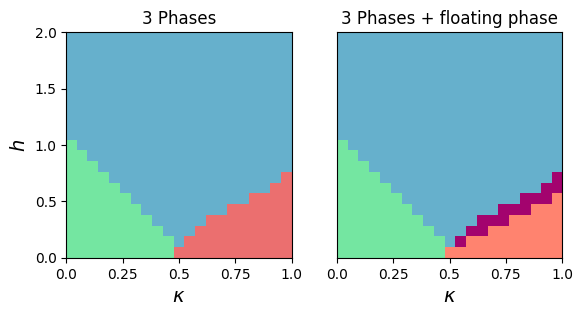

In [170]:
TT.plot_labels()

In [47]:
TT.MPS[10].towave()

Array([ 6.1767095e-01, -5.5594743e-16, -1.1555461e-15, ...,
       -2.3075802e-18, -3.5792362e-18,  2.9119232e-04], dtype=float32)